# QMDA Final Project

Goal here is to put uncertainty estimates on my gridded averages. Might also play around with lateral gradient problems, but not sure if I'll get to that or not.

In [61]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid
from tqdm import tqdm
from dask.diagnostics import ProgressBar

In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff

In [3]:
# Set title size
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16  # Titles larger

# Set axis label size
plt.rcParams['axes.labelsize'] = 14  # Labels slightly smaller

In [4]:
ds_p = xr.open_dataset('/swot/SUM05/amf2288/res_2.5/ds_p.nc')

In [163]:
section = ds_p.where(ds_p.LONGITUDE<0).where(ds_p.LONGITUDE>60)

In [164]:
section

<xarray.Dataset> Size: 95GB
Dimensions:            (N_PROF: 1488063, PRES_INTERPOLATED: 1001)
Coordinates:
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1996 1998 2000
    TIME               (N_PROF) datetime64[ns] 12MB 2024-01-31T06:16:20 ... 2...
    LATITUDE           (N_PROF) float64 12MB -78.16 -78.15 ... 89.77 89.78
    LONGITUDE          (N_PROF) float64 12MB -174.6 -161.6 ... -99.35 139.1
  * N_PROF             (N_PROF) int64 12MB 2428701 1114461 ... 1502504 411205
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 12GB nan nan ... nan
    CYCLE_NUMBER       (N_PROF, PRES_INTERPOLATED) float64 12GB nan nan ... nan
    PLATFORM_NUMBER    (N_PROF, PRES_INTERPOLATED) float64 12GB nan nan ... nan
    PRES               (N_PROF, PRES_INTERPOLATED) float32 6GB nan nan ... nan
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 6GB nan nan ... nan
    SA                 (N_PROF, PRES_INTERPOLATED) float64 12GB nan nan ... nan
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 12GB nan nan ... nan
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 6GB nan nan ... nan
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 6GB nan nan ... nan
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 12GB nan nan ... nan
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [ ]:
x = 'LATITUDE'
section.CT.sortby(x).plot(x=x, y='PRES_INTERPOLATED',cbar=cmo.thermal)
plt.title("'Section' of Argo Temperature Profiles")

In [ ]:
x = 'LATITUDE'
section.SA.sortby(x).plot(x=x, y='PRES_INTERPOLATED',cbar=cmo.haline)
plt.title("'Section' of Argo Salinity Profiles")

In [36]:
lfilt = 100
rho_grid = np.arange(21,29,0.0025)
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-90,91,3)

In [5]:
ct_e = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_e_3.nc', chunks={'N_PROF':100000})
sa_e = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_e_3.nc', chunks={'N_PROF':100000})

In [19]:
ct_e = ct_e.rename({'N_PROF':'profile','PRES_INTERPOLATED':'pressure','LATITUDE':'lat','LONGITUDE':'lon','N_PROF_NEW':'prof_new'})
sa_e = sa_e.rename({'N_PROF':'profile','PRES_INTERPOLATED':'pressure','LATITUDE':'lat','LONGITUDE':'lon','N_PROF_NEW':'prof_new'})

In [75]:
ct_m = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_3.nc', chunks={'N_PROF':100000})
sa_m = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_m_3.nc', chunks={'N_PROF':100000})

In [76]:
ct_m = ct_m.rename({'N_PROF':'profile','PRES_INTERPOLATED':'pressure','LATITUDE':'lat','LONGITUDE':'lon','N_PROF_NEW':'prof_new'})
sa_m = sa_m.rename({'N_PROF':'profile','PRES_INTERPOLATED':'pressure','LATITUDE':'lat','LONGITUDE':'lon','N_PROF_NEW':'prof_new'})

In [22]:
ct_e_z2 = ct_e.differentiate(coord='pressure')**2
sa_e_z2 = sa_e.differentiate(coord='pressure')**2

In [78]:
ct_m_z2 = ct_m.differentiate(coord='pressure')**2
sa_m_z2 = sa_m.differentiate(coord='pressure')**2

In [24]:
%%time
ct_e_z2_filt = ff.da_filt_single(ct_e_z2, lfilt, dim1='profile', dim2='pressure')
sa_e_z2_filt = ff.da_filt_single(sa_e_z2, lfilt, dim1='profile', dim2='pressure')

CPU times: user 3min 10s, sys: 57.7 s, total: 4min 8s
Wall time: 3min 32s


In [25]:
ct_e_z2_filt.name = 'ct_e_z2_filt'
ct_e_z2_filt = ct_e_z2_filt.to_dataset()

sa_e_z2_filt.name = 'sa_e_z2_filt'
sa_e_z2_filt = sa_e_z2_filt.to_dataset()

In [79]:
ct_m_z2.name = 'ct_m_z2'
ct_m_z2 = ct_m_z2.to_dataset()

sa_m_z2.name = 'sa_m_z2'
sa_m_z2 = sa_m_z2.to_dataset()

In [62]:
def get_ds_gridded(ds, lon_bins, lat_bins):
    """
    Bin profiles into lon/lat boxes and compute mean, std, and count
    for ct_e_z2_filt across pressure levels.
    """

    def reduce_with_progress(func, skipna=True, suffix=""):
        print(f"\nStarting {func} reduction...")
        with ProgressBar():  # separate progress bar for each flox call
            out = xarray_reduce(
                ds,
                'lon',        # bin by longitude
                'lat',        # bin by latitude
                func=func,
                expected_groups=(
                    pd.IntervalIndex.from_breaks(lon_bins),
                    pd.IntervalIndex.from_breaks(lat_bins)
                ),
                fill_value=np.nan,
                skipna=skipna
            ).compute()
        # Rename variable to avoid merge conflicts
        out = out.rename({var: f"{var}{suffix}" for var in out.data_vars})
        print(f"{func} reduction complete.")
        return out

    # Step 1: Compute mean, std, count
    ds_mean  = reduce_with_progress('mean',  skipna=True,  suffix="_mean")
    ds_std   = reduce_with_progress('std',   skipna=True,  suffix="_std")
    ds_count = reduce_with_progress('count', skipna=False, suffix="_count")

    # Step 2: Merge results
    ds_binned = xr.merge([ds_mean, ds_std, ds_count])

    # Step 3: Rename bin dimensions
    ds_binned = ds_binned.rename_dims({
        'lon_bins': 'lon',
        'lat_bins': 'lat'
    }).rename_vars({
        'lon_bins': 'lon',
        'lat_bins': 'lat'
    })

    # Step 4: Replace Interval coordinates with midpoints
    def interval_midpoints(intervals):
        return np.array([interval.mid for interval in intervals])

    ds_binned = ds_binned.assign_coords({
        'lon': ('lon', interval_midpoints(ds_binned['lon'].values)),
        'lat': ('lat', interval_midpoints(ds_binned['lat'].values))
    })

    # Step 5: Generate grid and xgcm object
    ds_gridded = generate_grid_ds(ds_binned, {'X': 'lon', 'Y': 'lat'})
    grid = Grid(ds_gridded, coords={
        'X': {'center': 'lon', 'left': 'lon_left'},
        'Y': {'center': 'lat', 'left': 'lat_left'},
        'Z': {'center': 'pressure'}  # keep pressure dimension
    }, periodic=['X'])

    return ds_gridded, grid

In [63]:
ct_var2, grid = get_ds_gridded(ct_e_z2_filt, lon_bins, lat_bins)


Starting mean reduction...
[########################################] | 100% Completed | 14.23 s
mean reduction complete.

Starting std reduction...
[########################################] | 100% Completed | 35.54 s
std reduction complete.

Starting count reduction...
[########################################] | 100% Completed | 6.65 s
count reduction complete.


In [74]:
sa_var2, grid = get_ds_gridded(sa_e_z2_filt, lon_bins, lat_bins)


Starting mean reduction...
[########################################] | 100% Completed | 8.01 s
mean reduction complete.

Starting std reduction...
[########################################] | 100% Completed | 18.56 s
std reduction complete.

Starting count reduction...
[########################################] | 100% Completed | 3.58 s
count reduction complete.


In [80]:
ct_var3, grid = get_ds_gridded(ct_m_z2, lon_bins, lat_bins)


Starting mean reduction...
[########################################] | 100% Completed | 24.10 s
mean reduction complete.

Starting std reduction...
[########################################] | 100% Completed | 30.14 s
std reduction complete.

Starting count reduction...
[########################################] | 100% Completed | 12.71 s
count reduction complete.


In [81]:
sa_var3, grid = get_ds_gridded(sa_m_z2, lon_bins, lat_bins)


Starting mean reduction...
[########################################] | 100% Completed | 22.68 s
mean reduction complete.

Starting std reduction...
[########################################] | 100% Completed | 30.05 s
std reduction complete.

Starting count reduction...
[########################################] | 100% Completed | 12.49 s
count reduction complete.


In [150]:
# Select one pressure level, e.g. 1000 dbar
pres = 1000
ct2_level = ct_var2.sel(pressure=pres)
ct3_level = ct_var3.sel(pressure=pres)

# Standard error of the mean
ct2_sem = ct2_level.ct_e_z2_filt_std / np.sqrt(ct2_level.ct_e_z2_filt_count)
ct3_sem = ct3_level.ct_m_z2_std / np.sqrt(ct3_level.ct_m_z2_count)

# 95% CI bounds
ct2_lower = ct2_level.ct_e_z2_filt_mean - 2 * ct2_sem
ct2_upper = ct2_level.ct_e_z2_filt_mean + 2 * ct2_sem
ct2_ci_width = ct2_upper - ct2_lower

ct3_lower = ct3_level.ct_m_z2_mean - 2 * ct3_sem
ct3_upper = ct3_level.ct_m_z2_mean + 2 * ct3_sem
ct3_ci_width = ct3_upper - ct3_lower

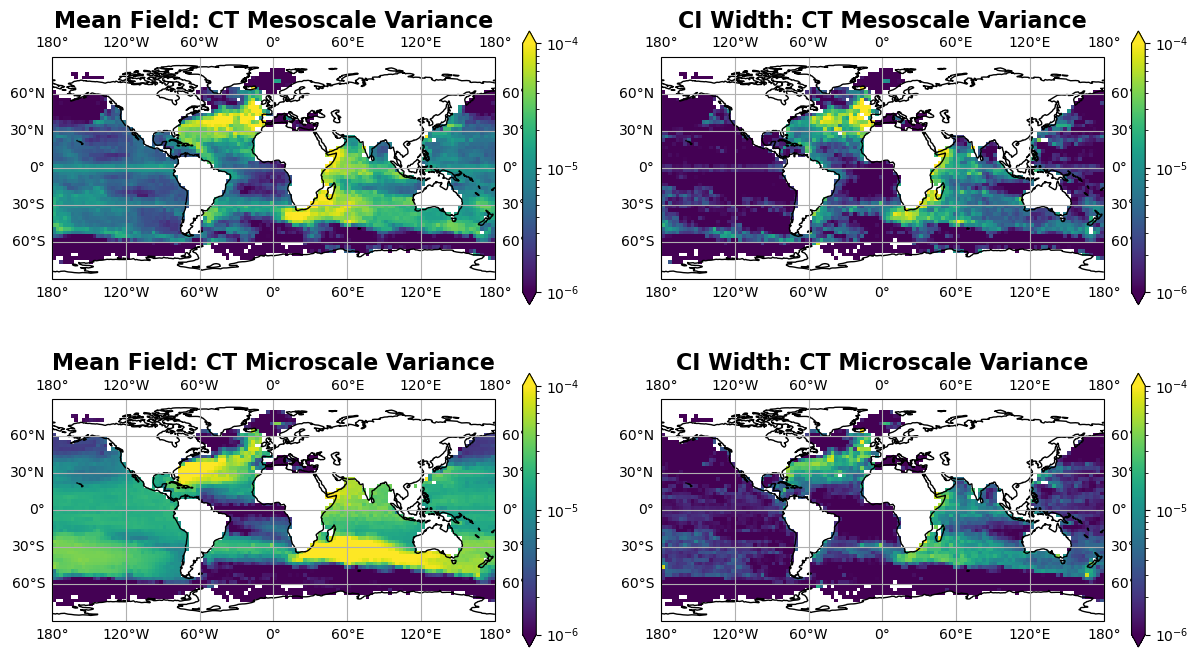

In [151]:
fig, axs = plt.subplots(2,2, figsize=(15,8), subplot_kw={'projection':ccrs.PlateCarree()})

ct2_level.ct_e_z2_filt_mean.plot(x='lon',y='lat',ax=axs[0,0],transform=ccrs.PlateCarree(),norm=colors.LogNorm(vmin=1e-6, vmax=1e-4),cbar_kwargs={'label':''})
axs[0,0].coastlines()
axs[0,0].gridlines(draw_labels=True)
axs[0,0].set_global()
axs[0,0].set_title("Mean Field: CT Mesoscale Variance")

ct2_ci_width.plot(x='lon',y='lat',ax=axs[0,1],transform=ccrs.PlateCarree(),norm=colors.LogNorm(vmin=1e-6, vmax=1e-4))
axs[0,1].coastlines()
axs[0,1].gridlines(draw_labels=True)
axs[0,1].set_global()
axs[0,1].set_title("CI Width: CT Mesoscale Variance")

ct3_level.ct_m_z2_mean.plot(x='lon',y='lat',ax=axs[1,0],transform=ccrs.PlateCarree(),norm=colors.LogNorm(vmin=1e-6, vmax=1e-4),cbar_kwargs={'label':''})
axs[1,0].coastlines()
axs[1,0].gridlines(draw_labels=True)
axs[1,0].set_global()
axs[1,0].set_title("Mean Field: CT Microscale Variance")

ct3_ci_width.plot(x='lon',y='lat',ax=axs[1,1],transform=ccrs.PlateCarree(),norm=colors.LogNorm(vmin=1e-6, vmax=1e-4))
axs[1,1].coastlines()
axs[1,1].gridlines(draw_labels=True)
axs[1,1].set_global()
axs[1,1].set_title("CI Width: CT Microscale Variance")

plt.subplots_adjust(wspace=0.1, hspace=0.25)

In [154]:
# Select one pressure level, e.g. 1000 dbar
pres = 1000
sa2_level = sa_var2.sel(pressure=pres)
sa3_level = sa_var3.sel(pressure=pres)

# Standard error of the mean
sa2_sem = sa2_level.sa_e_z2_filt_std / np.sqrt(sa2_level.sa_e_z2_filt_count)
sa3_sem = sa3_level.sa_m_z2_std / np.sqrt(sa3_level.sa_m_z2_count)

# 95% CI bounds
sa2_lower = sa2_level.sa_e_z2_filt_mean - 2 * sa2_sem
sa2_upper = sa2_level.sa_e_z2_filt_mean + 2 * sa2_sem
sa2_ci_width = sa2_upper - sa2_lower

sa3_lower = sa3_level.sa_m_z2_mean - 2 * sa3_sem
sa3_upper = sa3_level.sa_m_z2_mean + 2 * sa3_sem
sa3_ci_width = sa3_upper - sa3_lower

Text(0.5, 1.0, 'CI Width: SA Microscale Variance')

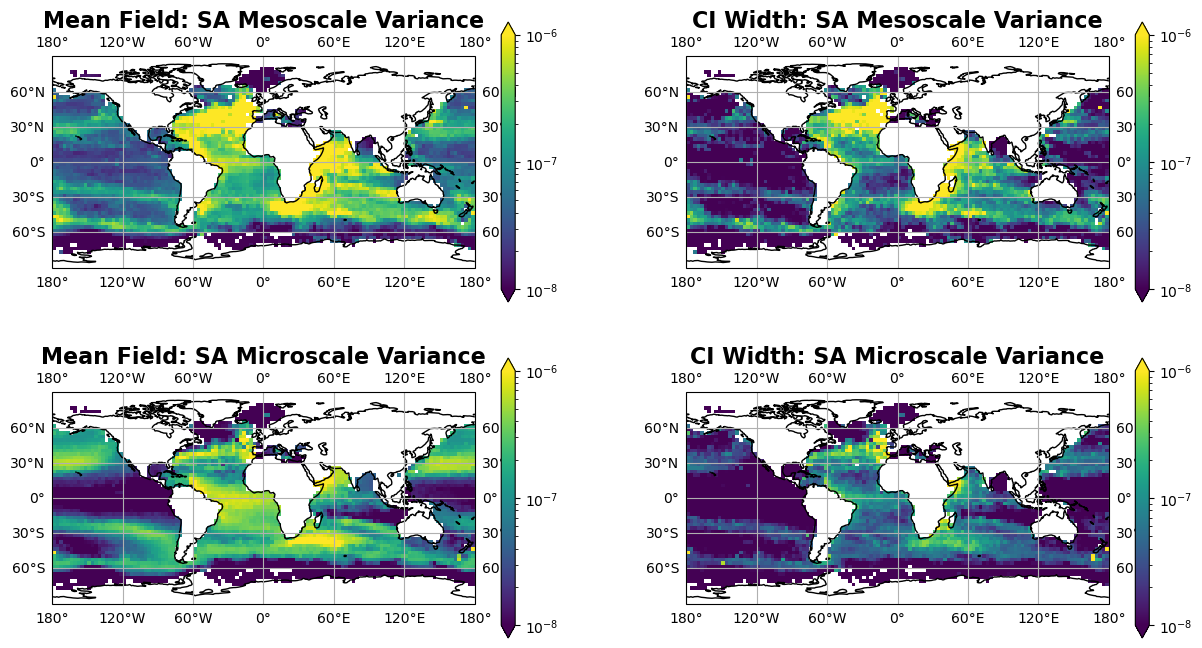

In [156]:
fig, axs = plt.subplots(2,2, figsize=(15,8), subplot_kw={'projection':ccrs.PlateCarree()})

sa2_level.sa_e_z2_filt_mean.plot(x='lon',y='lat',ax=axs[0,0],transform=ccrs.PlateCarree(),norm=colors.LogNorm(vmin=1e-8, vmax=1e-6),cbar_kwargs={'label':''})
axs[0,0].coastlines()
axs[0,0].gridlines(draw_labels=True)
axs[0,0].set_global()
axs[0,0].set_title("Mean Field: SA Mesoscale Variance")

sa2_ci_width.plot(x='lon',y='lat',ax=axs[0,1],transform=ccrs.PlateCarree(),norm=colors.LogNorm(vmin=1e-8, vmax=1e-6))
axs[0,1].coastlines()
axs[0,1].gridlines(draw_labels=True)
axs[0,1].set_global()
axs[0,1].set_title("CI Width: SA Mesoscale Variance")

sa3_level.sa_m_z2_mean.plot(x='lon',y='lat',ax=axs[1,0],transform=ccrs.PlateCarree(),norm=colors.LogNorm(vmin=1e-8, vmax=1e-6),cbar_kwargs={'label':''})
axs[1,0].coastlines()
axs[1,0].gridlines(draw_labels=True)
axs[1,0].set_global()
axs[1,0].set_title("Mean Field: SA Microscale Variance")

sa3_ci_width.plot(x='lon',y='lat',ax=axs[1,1],transform=ccrs.PlateCarree(),norm=colors.LogNorm(vmin=1e-8, vmax=1e-6))
axs[1,1].coastlines()
axs[1,1].gridlines(draw_labels=True)
axs[1,1].set_global()
axs[1,1].set_title("CI Width: SA Microscale Variance")


## Confidence Intervals for One Box

In [204]:
lon_up = -24
lon_lo = -27
lon_mid = 0.5*(lon_up - lon_lo) + lon_lo

lat_up = 42
lat_lo = 39
lat_mid = 0.5*(lat_up - lat_lo) + lat_lo

In [ ]:
lat_mask = ((ct_e_z2_filt.lat < lat_up) & (ct_e_z2_filt.lat > lat_lo)).compute()
lon_mask = ((ct_e_z2_filt.lon < lon_up) & (ct_e_z2_filt.lon > lon_lo)).compute()

In [254]:
profs_ct = ds_p.rename({'N_PROF':'profile','PRES_INTERPOLATED':'pressure','LATITUDE':'lat','LONGITUDE':'lon'}).CT.where(lat_mask & lon_mask, drop=True).sortby('lat')
profs_sa = ds_p.rename({'N_PROF':'profile','PRES_INTERPOLATED':'pressure','LATITUDE':'lat','LONGITUDE':'lon'}).SA.where(lat_mask & lon_mask, drop=True).sortby('lat')

In [ ]:
ds_p_

In [195]:
profs_ct_var2 = ct_e_z2_filt.where(lat_mask & lon_mask, drop=True).sortby('lat').ct_e_z2_filt
profs_sa_var2 = sa_e_z2_filt.where(lat_mask & lon_mask, drop=True).sortby('lat').sa_e_z2_filt

In [234]:
# Select one pressure level, e.g. 1000 dbar
box_ct_var2 = ct_var2.sel(lon=lon_mid, lat=lat_mid)
box_sa_var2 = sa_var2.sel(lon=lon_mid, lat=lat_mid)

# Mean profile
mean_ct_var2 = box_ct_var2.ct_e_z2_filt_mean
mean_sa_var2 = box_sa_var2.sa_e_z2_filt_mean

# Standard error of the mean
ct2_sem = box_ct_var2.ct_e_z2_filt_std #/ np.sqrt(box_ct_var2.ct_e_z2_filt_count)
sa2_sem = box_sa_var2.sa_e_z2_filt_std #/ np.sqrt(box_sa_var2.sa_e_z2_filt_count)

# 95% CI bounds
ct2_lower = mean_ct_var2 - 2 * ct2_sem
ct2_upper = mean_ct_var2 + 2 * ct2_sem
ct2_ci_width = ct2_upper - ct2_lower

sa2_lower = mean_sa_var2 - 2 * sa2_sem
sa2_upper = mean_sa_var2 + 2 * sa2_sem
sa2_ci_width = sa2_upper - sa2_lower

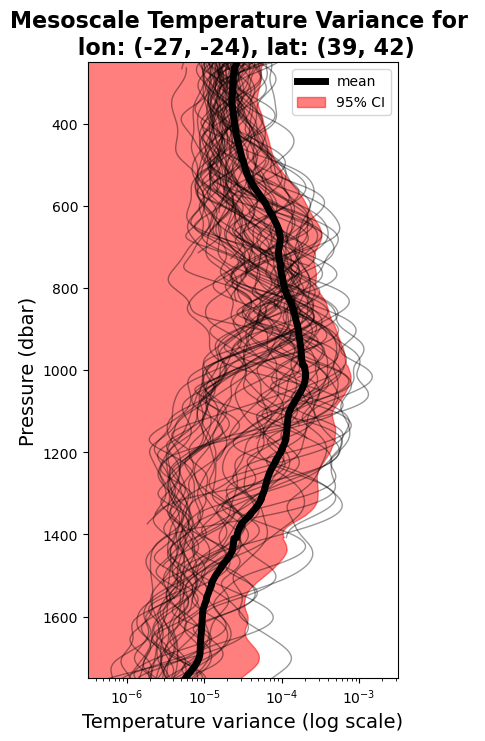

In [251]:
plt.figure(figsize=(4,8))

# Plot all profiles
for n in range(0, len(profs_sa_var2)):
    profs_ct_var2.isel(profile=n).plot(y='pressure', color='k', alpha=0.4, linewidth=1)

# Plot mean profile
mean_ct_var2.plot(y='pressure', color='k', linewidth=5, label='mean')

# Add shaded confidence interval
plt.fill_betweenx(
    ct2_lower['pressure'],   # y-axis (pressure)
    ct2_lower.values,        # lower bound
    ct2_upper.values,        # upper bound
    color='red', alpha=0.5, label='95% CI')

# Axis formatting
plt.ylim(1750, 250)
plt.ylabel('Pressure (dbar)')
plt.xscale('log')
plt.xlim(10**-6.5, 10**-2.5)
plt.xlabel('Temperature variance (log scale)')
plt.title(f'Mesoscale Temperature Variance for \n lon: ({lon_lo}, {lon_up}), lat: ({lat_lo}, {lat_up})')
plt.legend()
plt.show()